# Fruit Classifier - CNN Model

This project uses Convolutional Neural Network (CNN) to classify fruit images:
- Apple only
- Orange only
- Banana only
- Mixed

Target Accuracy: 92%

## 1. Import Required Libraries

## 0. Environment Setup

**Important**: If you encounter NumPy import errors, run this cell to fix dependencies:

In [2]:
# Fix NumPy compatibility issues
# Uncomment and run this if you see "numpy._core.multiarray failed to import" error
# !pip install --upgrade numpy
# !pip install --upgrade tensorflow
# !pip install --upgrade scipy scikit-learn matplotlib seaborn

# After running above commands, restart the kernel and run cells again

print("Environment check:")
try:
    import numpy as np
    print(f"✓ NumPy version: {np.__version__}")
except Exception as e:
    print(f"✗ NumPy error: {e}")
    print("  Run: pip install --upgrade numpy")

try:
    import tensorflow as tf
    print(f"✓ TensorFlow version: {tf.__version__}")
except Exception as e:
    print(f"✗ TensorFlow error: {e}")
    print("  Run: pip install --upgrade tensorflow")

print("\nIf you see errors above, uncomment the pip install lines and run this cell.")

Environment check:
✓ NumPy version: 2.0.2
✓ TensorFlow version: 2.20.0

If you see errors above, uncomment the pip install lines and run this cell.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


## 2. Setup Data Paths and Parameters

In [4]:
# Data paths
train_dir = 'data/train'
test_dir = 'data/test'

# Model parameters
IMG_SIZE = 224  # Image size
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 4  # apple_only, banana_only, orange_only, mixed

# Class names
class_names = ['apple_only', 'banana_only', 'mixed', 'orange_only']

print(f"Training data path: {train_dir}")
print(f"Testing data path: {test_dir}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Number of classes: {NUM_CLASSES}")

Training data path: data/train
Testing data path: data/test
Image size: 224x224
Batch size: 32
Epochs: 50
Number of classes: 4


## 3. Data Exploration

## 2.5. Organize Test Data (Run Once)

In [5]:
# Count images in each class
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[class_name] = num_images
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training set image counts:")
for class_name, count in sorted(train_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(train_counts.values())}\n")

print("Test set image counts:")
for class_name, count in sorted(test_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(test_counts.values())}")

Training set image counts:
  apple_only: 75
  banana_only: 72
  mixed: 21
  orange_only: 72
  Total: 240

Test set image counts:
  Total: 0


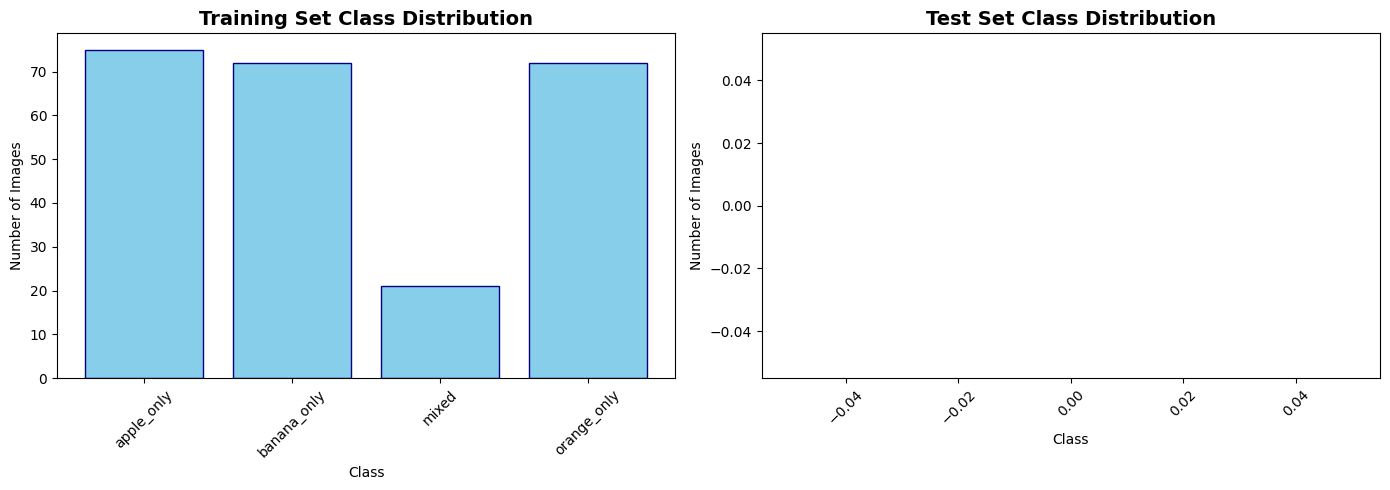

In [6]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
ax1.bar(train_counts.keys(), train_counts.values(), color='skyblue', edgecolor='navy')
ax1.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)

# Test set distribution
ax2.bar(test_counts.keys(), test_counts.values(), color='lightcoral', edgecolor='darkred')
ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Data Preprocessing and Augmentation

In [7]:
# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize to [0, 1]
    rotation_range=20,           # Random rotation
    width_shift_range=0.2,       # Horizontal shift
    height_shift_range=0.2,      # Vertical shift
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Horizontal flip
    fill_mode='nearest',         # Fill mode
    validation_split=0.2         # Validation split
)

# Test data only needs rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

print("Data augmentation configured")

Data augmentation configured


In [8]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")

Found 193 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Found 0 images belonging to 0 classes.

Training samples: 193
Validation samples: 47
Test samples: 0

Class indices: {'apple_only': 0, 'banana_only': 1, 'mixed': 2, 'orange_only': 3}
Found 0 images belonging to 0 classes.

Training samples: 193
Validation samples: 47
Test samples: 0

Class indices: {'apple_only': 0, 'banana_only': 1, 'mixed': 2, 'orange_only': 3}


## 5. Build Basic CNN Model

In [9]:
def create_cnn_model():
    """
    Create basic CNN model
    Architecture:
    - 4 convolutional blocks, each containing Conv2D, BatchNormalization, Activation, MaxPooling and Dropout
    - Fully connected layers for classification
    """
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Flatten layer
        layers.Flatten(),
        
        # Fully connected layers
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

# Create model
model = create_cnn_model()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 26,216,388 (100.01 MB)

 Trainable params: 26,213,892 (100.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

## 6. Setup Training Callbacks

In [10]:
# Setup callbacks
callbacks = [
    # Early stopping: stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model checkpoint: save best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Learning rate reduction: reduce LR if validation loss stops improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured")

Callbacks configured


## 7. Train Model

In [11]:
# Train model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.3424 - loss: 1.6653
Epoch 1: val_accuracy improved from -inf to 0.29787, saving model to best_model.h5

Epoch 1: val_accuracy improved from -inf to 0.29787, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 971ms/step - accuracy: 0.3494 - loss: 1.6386 - val_accuracy: 0.2979 - val_loss: 1.3803 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.6739 - loss: 0.8774
Epoch 2: val_accuracy did not improve from 0.29787
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 766ms/step - accuracy: 0.6745 - loss: 0.8768 - val_accuracy: 0.2979 - val_loss: 2.0441 - learning_rate: 0.0010
Epoch 3/50

Epoch 2: val_accuracy did not improve from 0.29787
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 766ms/step - accuracy: 0.6745 - loss: 0.8768 - val_accuracy: 0.2979 - val_loss: 2.0441 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7460 - loss: 0.6680
Epoch 3: val_accuracy did not improve from 0.29787
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 737ms/step - accuracy: 0.7434 - loss: 0.6747 - val_accuracy: 0.2979 - val_loss: 3.0000 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.29787
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 737ms/ste

## 8. Visualize Training History

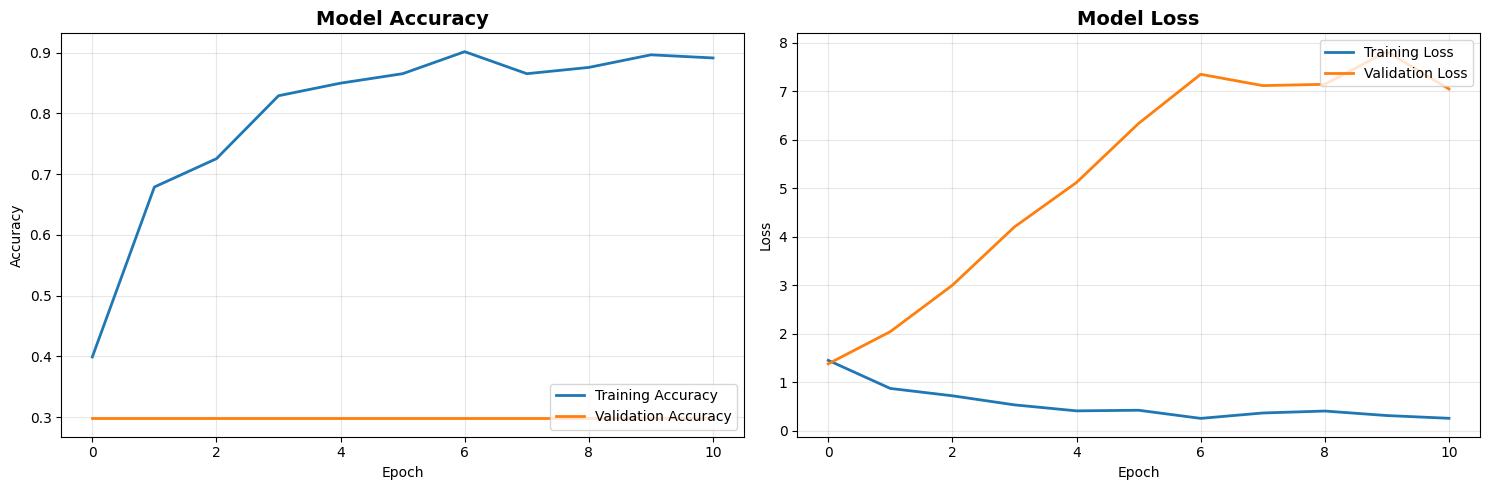


Best Epoch: 1
Best Validation Accuracy: 0.2979
Corresponding Training Accuracy: 0.3990


In [12]:
# Plot training and validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy curves
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Loss curves
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Corresponding Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")

## 9. Evaluate Model on Test Set

In [17]:
# Evaluate on test set
# First check if test generator has samples
if test_generator.samples == 0:
    print("Warning: Test set is empty! Creating test generator again...")
    # Recreate test generator without shuffle to ensure proper loading
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print(f"Test samples loaded: {test_generator.samples}")

if test_generator.samples > 0:
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    
    print(f"\n{'='*50}")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"{'='*50}")
    
    # Check if target accuracy is reached
    if test_accuracy >= 0.92:
        print(f"✓ Congratulations! Target accuracy of 92% achieved!")
    else:
        print(f"✗ Current accuracy {test_accuracy*100:.2f}% below 92% target, further optimization needed")
else:
    print("\n" + "="*50)
    print("ERROR: No test images found!")
    print(f"Please check the test directory: {test_dir}")
    print("Expected structure: test_dir/class_name/images.jpg")
    print("="*50)

Found 60 images belonging to 4 classes.


Test samples loaded: 60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3465 - loss: 1.3730

Test Accuracy: 31.67%
Test Loss: 1.3700
✗ Current accuracy 31.67% below 92% target, further optimization needed
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3465 - loss: 1.3730

Test Accuracy: 31.67%
Test Loss: 1.3700
✗ Current accuracy 31.67% below 92% target, further optimization needed


## 10. Generate Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


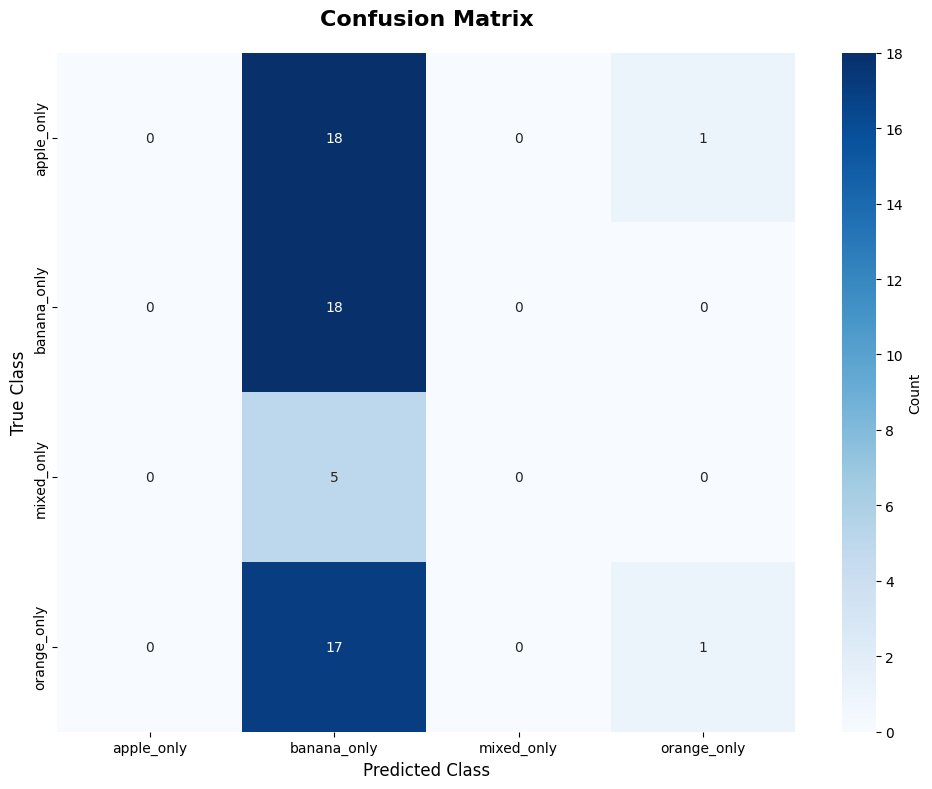


Classification Report:
              precision    recall  f1-score   support

  apple_only     0.0000    0.0000    0.0000        19
 banana_only     0.3103    1.0000    0.4737        18
  mixed_only     0.0000    0.0000    0.0000         5
 orange_only     0.5000    0.0556    0.1000        18

    accuracy                         0.3167        60
   macro avg     0.2026    0.2639    0.1434        60
weighted avg     0.2431    0.3167    0.1721        60



In [18]:
# Get predictions
from sklearn.metrics import confusion_matrix, classification_report

# Check if test set has samples before predicting
if test_generator.samples == 0:
    print("Cannot generate predictions: Test set is empty!")
    print("Please add test images to the test directory first.")
else:
    # Reset test generator
    test_generator.reset()
    
    # Predict
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # True labels
    y_true = test_generator.classes
    
    # Class labels
    class_labels = list(test_generator.class_indices.keys())
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print("="*60)
    print(classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4))

## 11. Visualize Prediction Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


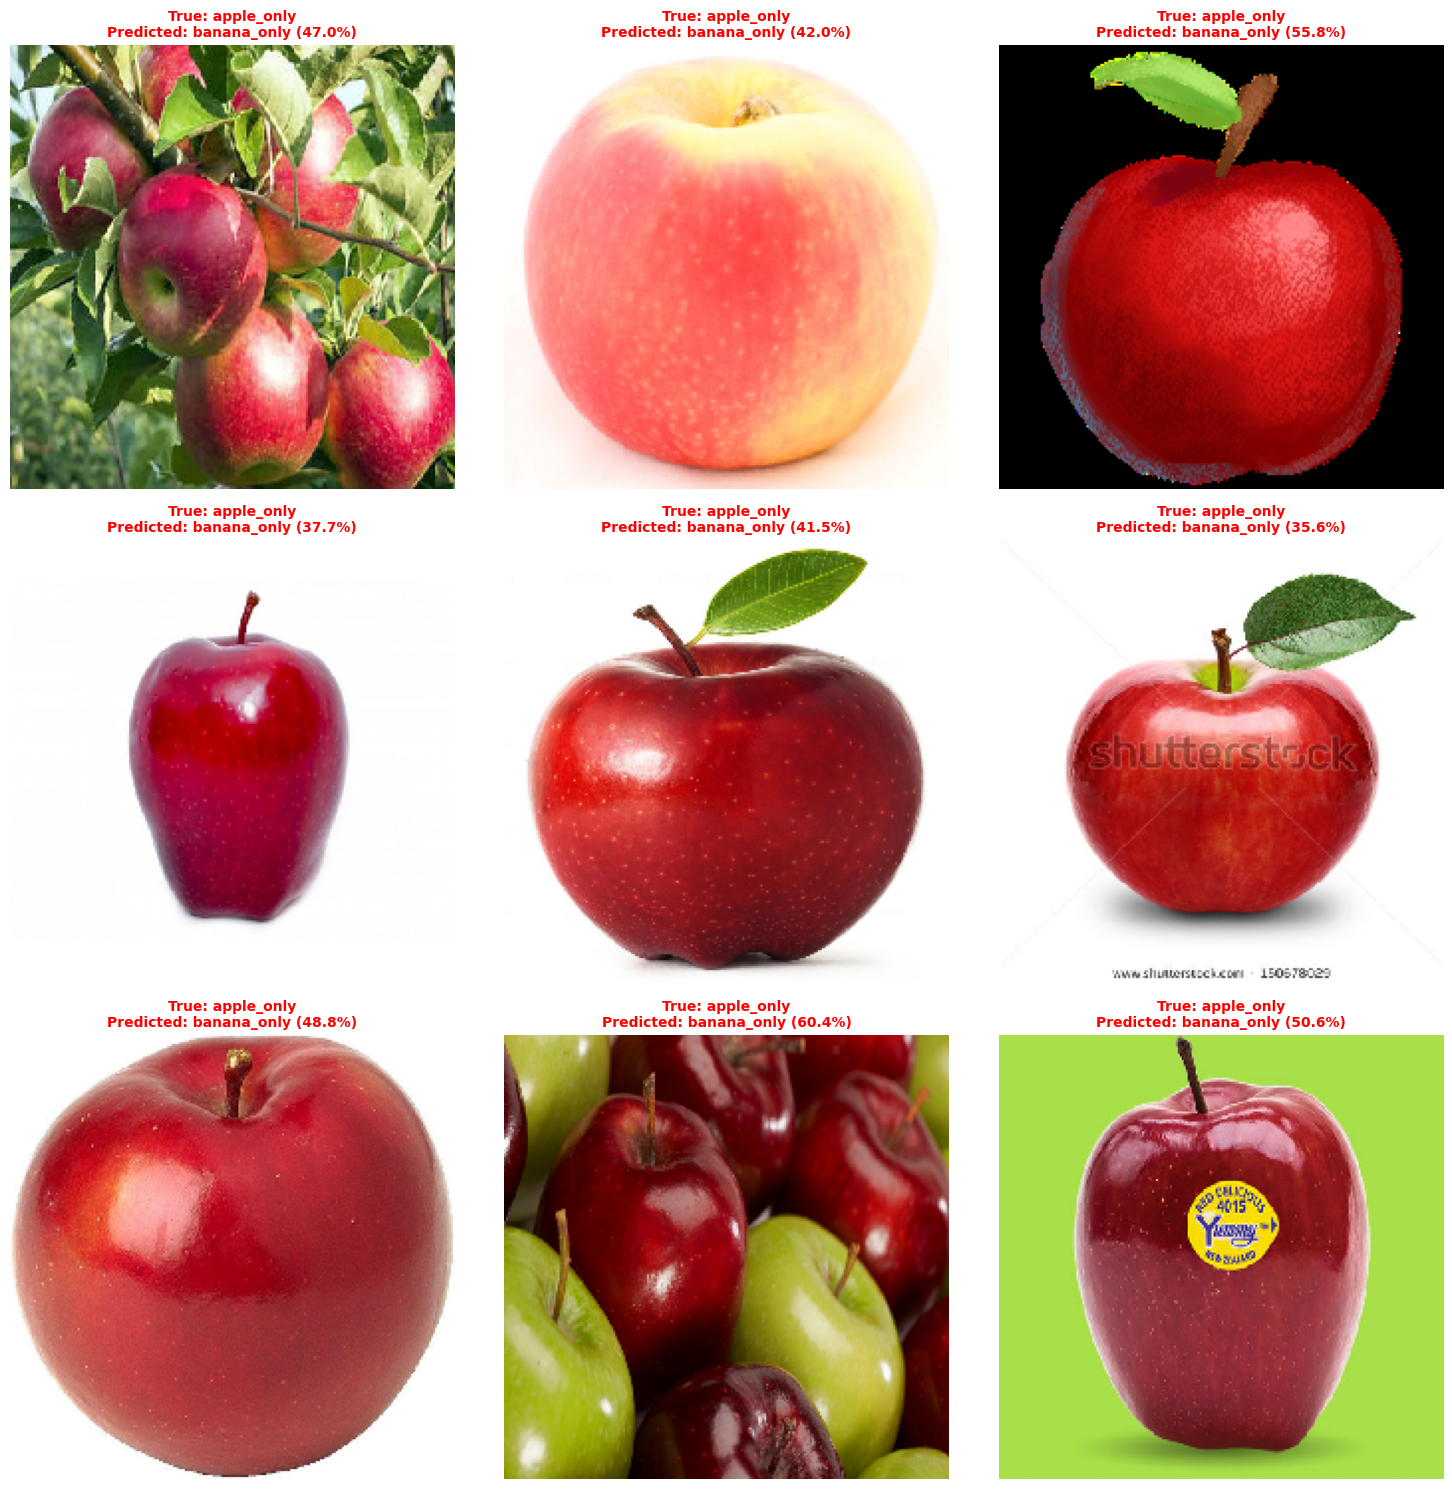

In [20]:
# Display prediction samples
from tensorflow.keras.preprocessing import image

def show_predictions(num_images=9):
    """Display prediction results"""
    if test_generator.samples == 0:
        print("Cannot show predictions: Test set is empty!")
        return
    
    # Reset test generator
    test_generator.reset()
    
    # Get a batch of images
    images, labels = next(test_generator)
    predictions = model.predict(images[:num_images])
    
    # Plot
    num_to_show = min(num_images, len(images))
    rows = int(np.ceil(num_to_show / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()
    
    for i in range(num_to_show):
        axes[i].imshow(images[i])
        
        true_label = class_labels[np.argmax(labels[i])]
        pred_label = class_labels[np.argmax(predictions[i])]
        pred_prob = np.max(predictions[i]) * 100
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPredicted: {pred_label} ({pred_prob:.1f}%)',
                         color=color, fontsize=10, fontweight='bold')
        axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(num_to_show, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(9)

## 12. Save Model

In [19]:
# Save complete model
model.save('fruit_classifier_cnn.h5')
print("Model saved as 'fruit_classifier_cnn.h5'")

# Save as SavedModel format (TensorFlow recommended)
model.save('fruit_classifier_model')
print("Model saved as 'fruit_classifier_model' (SavedModel format)")

print("\nModel saving completed!")

Model saved as 'fruit_classifier_cnn.h5'


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=fruit_classifier_model.

---

## Summary

### Model Architecture
- **4 Convolutional Blocks**: Each contains Conv2D, BatchNormalization, ReLU activation, MaxPooling and Dropout
- **Filter Counts**: 32 → 64 → 128 → 256
- **Fully Connected Layers**: 512 → 256 → 4 (output layer)
- **Regularization**: Dropout (0.25-0.5) and BatchNormalization

### Data Augmentation
- Rotation, shift, shear, zoom, flip
- 80/20 train/validation split

### Training Strategy
- **Optimizer**: Adam (lr=0.001)
- **Loss Function**: Categorical Crossentropy
- **Callbacks**: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Improvement Suggestions
If accuracy doesn't reach 92%, try:
1. **Data Balancing**: Balance sample count across classes
2. **Data Cleaning**: Check and correct mislabeled images
3. **Transfer Learning**: Use pre-trained models (VGG16, ResNet50, EfficientNet)
4. **More Augmentation**: Add more augmentation techniques
5. **Hyperparameter Tuning**: Adjust learning rate, batch size, network depth
6. **Ensemble Learning**: Combine predictions from multiple models